Importa as bibliotecas necessárias para o pré-processamento do Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk as nltk
from nltk.corpus import stopwords

In [2]:
%matplotlib inline

Carrega o Dataset bruto

In [3]:
df_prop = pd.read_excel('dataset_full_feats.xlsx')

Visualiza informações básicas do conteúdo do Dataset

In [4]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46319 entries, 0 to 46318
Data columns (total 11 columns):
COD_PROP    46319 non-null int64
ANO         46319 non-null int64
NUM_PROP    46319 non-null int64
NOM_PROP    46319 non-null object
TEMAS       46319 non-null object
POLITICO    33402 non-null object
SEXO        33402 non-null object
PARTIDO     33333 non-null object
UF          33380 non-null object
REGIAO      33380 non-null object
TEXTO       46319 non-null object
dtypes: int64(3), object(8)
memory usage: 3.9+ MB


In [5]:
df_prop.head(3)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR (UT...",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...
1,132228,2003,1923,PL 1923/2003,ARTE E CULTURA,BETO ALBUQUERQUE,M,PSB,RIO GRANDE DO SUL,SUL,Confere ao município de Passo Fundo o título d...
2,118055,2003,1165,PL 1165/2003,ARTE E CULTURA,ELIMAR MÁXIMO DAMASCENO,M,PRONA,SÃO PAULO,SUDESTE,Inscreve o nome de Heitor Villa-Lobos no Livro...


Identifica a quantidade total de temas presentes no Dataset

In [6]:
df_prop['TEMAS'].nunique()

585

Elimina o texto "(UTILIZADO ATE A LEGISLATURA 53)" existente em alguns nomes de temas para melhorar visualização e operação com os temas.

In [7]:
for index, tema in df_prop.iterrows():
    legis_53 = '(UTILIZADO ATE A LEGISLATURA 53)'
    if legis_53 in tema['TEMAS']:
        tema_processado = tema['TEMAS'].replace(legis_53, '')
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_processado

In [8]:
df_prop.head(1)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...


In [9]:
df_prop['TEMAS'].nunique()

585

Mostra a quantidade de entradas para cada um dos temas existentes

In [10]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                                                                8466
TRABALHO E EMPREGO                                                                          2455
ADMINISTRACAO PUBLICA                                                                       2356
EDUCACAO                                                                                    2073
TRIBUTACAO                                                                                  2056
DIREITO PENAL E PROCESSUAL PENAL                                                            1788
SAUDE                                                                                       1539
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                                      1439
VIACAO E TRANSPORTES                                                                        1359
HOMENAGENS E DATAS COMEMORATIVAS                                                            1219
DIREITO CIVIL E PROCESSUAL CIV

Identificado diversos temas que possuem subtemas e portanto estão sendo identificados pelo código como categorias distintas. 
Para resolver isso o código abaixo agrega todos os temas que possuem subtemas em seu tema primário, salvo algumas exceções.

In [11]:
excecoes = ['RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA', 
            'DIREITOS HUMANOS, MINORIAS E CIDADANIA', 
            'ORGANIZACAO POLITICA, PARTIDARIA E ELEITORAL',
            'ECONOMIA, ADMINISTRACAO FINANCEIRA E ORCAMENTARIA',
            'INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR', 
            'INDUSTRIA, COMERCIO E ABASTECIMENTO',
            'AGRICULTURA, PECUARIA E PESCA']
for index, tema in df_prop.iterrows():
    virgula = ','
    if virgula in tema['TEMAS']:
        if not tema['TEMAS'] in excecoes and not tema['TEMAS'].startswith(str(map(lambda e: e, excecoes))): 
            tema_principal = tema['TEMAS'].split(',')[0]
            if tema_principal.endswith(' '):
                tema_principal = tema_principal.rstrip(' ')
            df_prop.at[df_prop.index[index], 'TEMAS'] = tema_principal

In [12]:
df_prop['TEMAS'].nunique()

47

In [13]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                         8854
ADMINISTRACAO PUBLICA                                3565
TRABALHO E EMPREGO                                   2591
EDUCACAO                                             2510
DIREITO PENAL E PROCESSUAL PENAL                     2318
TRIBUTACAO                                           2136
SAUDE                                                1799
INDUSTRIA                                            1612
DIREITO CIVIL E PROCESSUAL CIVIL                     1536
DESENVOLVIMENTO URBANO E TRANSITO                    1465
DIREITOS HUMANOS, MINORIAS E CIDADANIA               1439
VIACAO E TRANSPORTES                                 1359
HOMENAGENS E DATAS COMEMORATIVAS                     1262
PREVIDENCIA E ASSISTENCIA SOCIAL                     1259
DIREITOS HUMANOS                                     1173
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL          1063
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO        1023
SEGURANCA PUBL

Realiza correções de nomes e agrega ainda mais algumas categorias para reduzir o número de Temas criando

In [14]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO ADMINISTRATIVA DO ESTADO'
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS'] and tema['TEMAS'].startswith(tema_chave):
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [15]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO '
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS'] and tema['TEMAS'].startswith(tema_chave):
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [16]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('INDUSTRIA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'INDUSTRIA E COMERCIO'

In [17]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('CIENCIA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'CIENCIA E TECNOLOGIA'

In [18]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('INFORMATICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'CIENCIA E TECNOLOGIA'

In [19]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('RECURSOS HIDRICOS'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA'

In [20]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('AGRICULTURA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'AGRICULTURA, PECUARIA E PESCA'

In [21]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('DIREITOS HUMANOS'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'DIREITOS HUMANOS'

In [22]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('ORGANIZACAO POLITICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'

In [23]:
for index, tema in df_prop.iterrows():
    if tema['TEMAS'].startswith('POLITICA ECONOMICA'):
        df_prop.at[df_prop.index[index], 'TEMAS'] = 'ECONOMIA'

In [24]:
df_prop['TEMAS'].nunique()

36

In [25]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

In [26]:
df_prop.sort_values(by='TEMAS', ascending=True, inplace=True)

In [27]:
df_prop.count()

COD_PROP    46319
ANO         46319
NUM_PROP    46319
NOM_PROP    46319
TEMAS       46319
POLITICO    33402
SEXO        33402
PARTIDO     33333
UF          33380
REGIAO      33380
TEXTO       46319
dtype: int64

Visualiza a distribuição das entradas entre os TEMAS

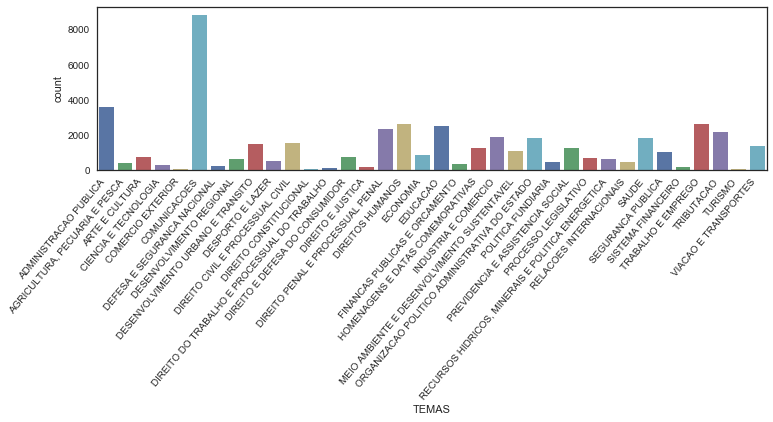

In [28]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_prop['TEMAS'], data=df_prop, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Verifica distribuição das entradas

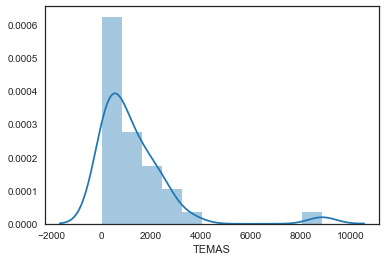

In [29]:
sns.distplot(df_prop['TEMAS'].value_counts())

Exibe a distribuição em porcentagem dos temas dentro do dataset

In [30]:
df_prop['TEMAS'].value_counts(normalize=True) * 100

COMUNICACOES                                         19.115266
ADMINISTRACAO PUBLICA                                 7.696626
DIREITOS HUMANOS                                      5.639155
TRABALHO E EMPREGO                                    5.593817
EDUCACAO                                              5.418943
DIREITO PENAL E PROCESSUAL PENAL                      5.004426
TRIBUTACAO                                            4.611499
INDUSTRIA E COMERCIO                                  4.013472
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         3.976770
SAUDE                                                 3.883935
DIREITO CIVIL E PROCESSUAL CIVIL                      3.316134
DESENVOLVIMENTO URBANO E TRANSITO                     3.162849
VIACAO E TRANSPORTES                                  2.934001
HOMENAGENS E DATAS COMEMORATIVAS                      2.724584
PREVIDENCIA E ASSISTENCIA SOCIAL                      2.718107
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

In [31]:
df_prop['TEXTO'].nunique()

44107

In [32]:
d_count = 0
d_list = df_prop['TEXTO'].duplicated()
d_list.dtype

dtype('bool')

Carrega arquivo do dataset que teve o texto já processado e tokenizado para análise

In [33]:
df_tokenized = pd.read_excel('Processed_File.xlsx')

In [34]:
df_tokenized['TOKENIZED'].describe()

count                              46319
unique                             40866
top        dá nov red art constitu feder
freq                                 123
Name: TOKENIZED, dtype: object

Pegas os indices de todas as entradas que estão duplicadas no dataset

In [35]:
duplicated_entries = []
for idx, v in df_tokenized.duplicated(subset='TOKENIZED', keep='first').iteritems():
    if v is True:
        duplicated_entries.append(idx)

Remove os itens duplicados do dataset

In [36]:
for idx, values in df_tokenized.iterrows():
    if idx in duplicated_entries:
        df_tokenized.drop(labels=idx, axis=0, inplace=True)

In [37]:
df_tokenized['TOKENIZED'].describe()

count                              40866
unique                             40866
top        institu dia cant popul brasil
freq                                   1
Name: TOKENIZED, dtype: object

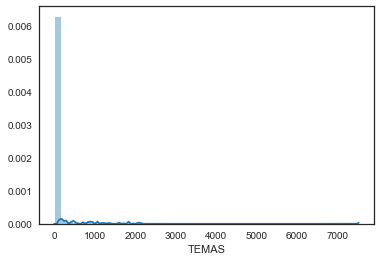

In [38]:
sns.distplot(df_tokenized['TEMAS'].value_counts())

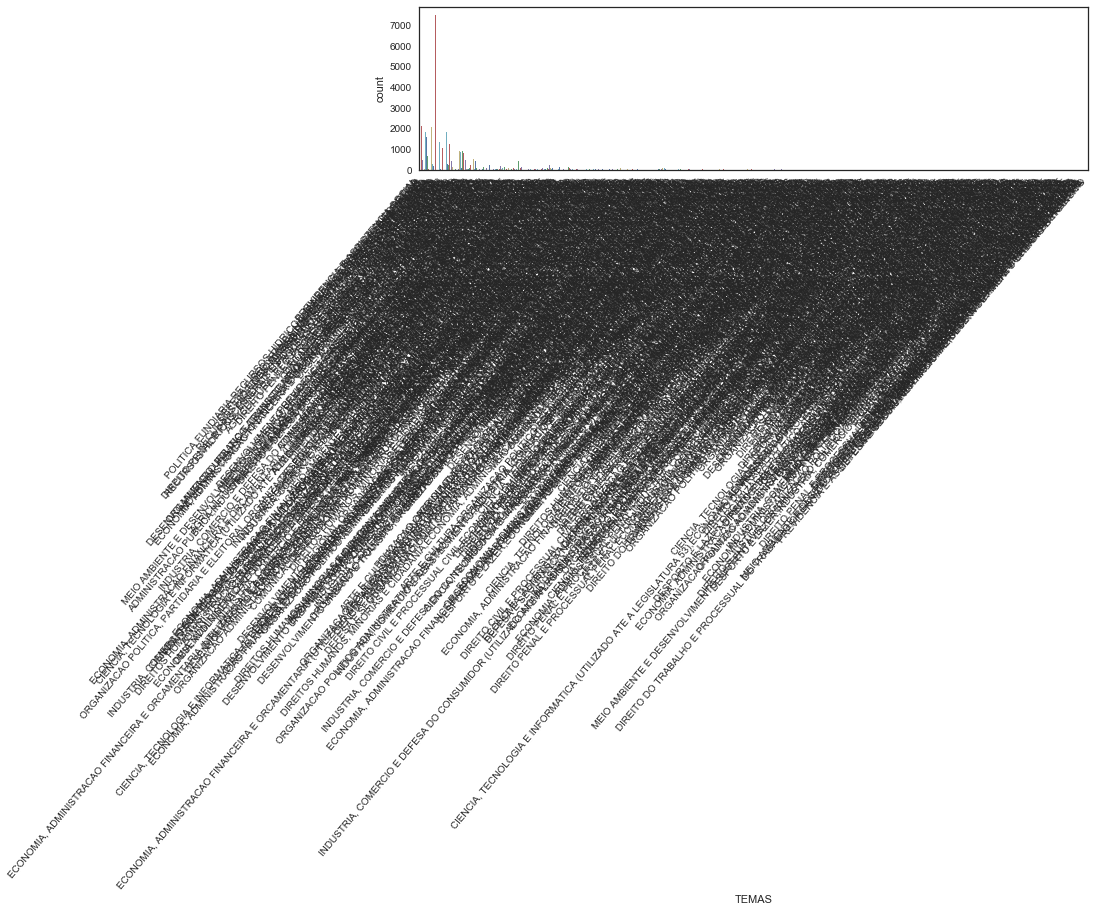

In [39]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_tokenized['TEMAS'], data=df_tokenized, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Distribuição em % dos TEMAS após limpeza de entradas duplicadas
Resultado: Ainda há uma discrepância grande entre representatividade das classes

In [40]:
df_tokenized['TEMAS'].value_counts(normalize=True) * 100

COMUNICACOES                                                                                  18.394264
TRABALHO E EMPREGO                                                                             5.221945
ADMINISTRACAO PUBLICA                                                                          5.048206
EDUCACAO                                                                                       4.531885
TRIBUTACAO                                                                                     4.448686
DIREITO PENAL E PROCESSUAL PENAL                                                               3.861401
SAUDE                                                                                          3.352420
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                                         3.102824
VIACAO E TRANSPORTES                                                                           2.919297
DIREITO CIVIL E PROCESSUAL CIVIL                                

**A seguir será analisado a correlação de outras variáveis com os TEMAS:**

Correlação de variáveis adicionais com TEMAS:

Carrega o dataset com oas novas variáveis

In [41]:
#dataset_full = pd.read_excel('dataset_full_feats.xlsx')
dataset_full = df_prop

Transformando as variáveis categóricas textuais em códigos para que possa ser calculado a correlação entre elas

In [42]:
#Cria novas variáveis com os códigos das categorias existentes
v_categ = ['TEMAS', 'POLITICO', 'SEXO', 'PARTIDO', 'UF', 'REGIAO']
prefix = 'CODE_'
corr_df_prop = dataset_full.copy()
for categ in v_categ:
    nv_categ = prefix + categ
    corr_df_prop[nv_categ] = dataset_full[categ]
    corr_df_prop[nv_categ] = pd.Categorical(corr_df_prop[nv_categ])
    corr_df_prop[nv_categ] = corr_df_prop[nv_categ].cat.codes

#Exibe a correlação:
corr_df_prop.corr()

,COD_PROP,ANO,NUM_PROP,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO
COD_PROP,1.000000,0.802261,0.026947,0.025664,0.118076,0.166733,0.159458,0.112276,0.120856
ANO,0.802261,1.000000,0.066040,0.036024,0.138859,0.171667,0.182300,0.126465,0.116366
NUM_PROP,0.026947,0.066040,1.000000,0.136674,0.117009,0.187467,0.119641,0.188661,0.186643
CODE_TEMAS,0.025664,0.036024,0.136674,1.000000,0.244531,0.368859,0.240344,0.307875,0.318741
CODE_POLITICO,0.118076,0.138859,0.117009,0.244531,1.000000,0.627560,0.462729,0.507170,0.514783
CODE_SEXO,0.166733,0.171667,0.187467,0.368859,0.627560,1.000000,0.650071,0.741863,0.772424
CODE_PARTIDO,0.159458,0.182300,0.119641,0.240344,0.462729,0.650071,1.000000,0.562842,0.561659
CODE_UF,0.112276,0.126465,0.188661,0.307875,0.507170,0.741863,0.562842,1.000000,0.821303
CODE_REGIAO,0.120856,0.116366,0.186643,0.318741,0.514783,0.772424,0.561659,0.821303,1.000000


Abaixo o Heatmap das correlações entre as variáveis. No que diz respeito aos temas, as características com maior correlação são SEXO, UF e REGIAO com valores dentro entre 0.3 e 0.4, seguido pelo POLITICO e PARTIDO, ambos com 0.25. 

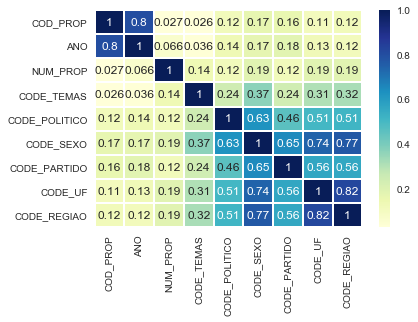

In [43]:
sns.heatmap(corr_df_prop.corr(), cmap='YlGnBu',linecolor='white',linewidths=1, annot=True)

In [44]:
corr_df_prop.head(3)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO
46318,149439,2003,2794,PL 2794/2003,ADMINISTRACAO PUBLICA,TADEU FILIPPELLI,M,PMDB,DISTRITO FEDERAL,CENTRO-OESTE,"Dispõe sobre a alteração da Lei nº 8.666, de 2...",0,1269,1,9,6,0
33669,475193,2010,7239,PL 7239/2010,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Acrescenta art. 31-A à Lei nº 8.987, de 13 de ...",0,-1,-1,-1,-1,-1
33674,585601,2013,6004,PL 6004/2013,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Regulamenta o art. 37, inciso II, da Constitui...",0,-1,-1,-1,-1,-1


Trata os valores nulos de todas as colunas categóricas do dataset

In [45]:
categ_v = ['SEXO', 'POLITICO', 'PARTIDO', 'UF', 'REGIAO', 'TEMAS']
for v in categ_v:
    corr_df_prop[v].fillna(value='NaN', method=None, inplace=True)

In [46]:
for v in categ_v:
    print(v + " " + str(corr_df_prop['SEXO'].isnull().sum()))

SEXO 0
POLITICO 0
PARTIDO 0
UF 0
REGIAO 0
TEMAS 0


Exporta para o Excel após correção dos valores nulos na colunas categóricas

In [47]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

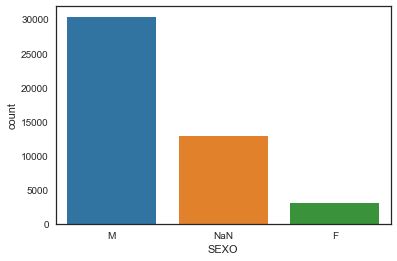

In [48]:
sns.countplot(x='SEXO',data=corr_df_prop)

In [49]:
corr_df_prop['SEXO'].value_counts()

M      30351
NaN    12917
F       3051
Name: SEXO, dtype: int64

Analisando quantidade de politicos por sexo:

In [50]:
print('Sexo Feminino: ' + str(corr_df_prop[corr_df_prop['SEXO'] == 'F']['POLITICO'].nunique()) +'\n'+
      'Sexo Masculino: ' + str(corr_df_prop[corr_df_prop['SEXO'] == 'M']['POLITICO'].nunique()))

Sexo Feminino: 137
Sexo Masculino: 1268


Visualizando a distribuição de proposições por tema e sexo:

In [51]:
print('SEXO FEMININO')
temas_f_perc = corr_df_prop[corr_df_prop['SEXO'] == 'F']['TEMAS'].value_counts(normalize=True) * 100
temas_f_perc

SEXO FEMININO


DIREITOS HUMANOS                                     12.651590
EDUCACAO                                              8.292363
ADMINISTRACAO PUBLICA                                 7.997378
TRABALHO E EMPREGO                                    7.767945
SAUDE                                                 6.588004
DIREITO PENAL E PROCESSUAL PENAL                      5.801377
HOMENAGENS E DATAS COMEMORATIVAS                      4.588659
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         4.195346
TRIBUTACAO                                            3.769256
DESENVOLVIMENTO URBANO E TRANSITO                     3.441495
INDUSTRIA E COMERCIO                                  3.375942
PREVIDENCIA E ASSISTENCIA SOCIAL                      3.310390
DIREITO CIVIL E PROCESSUAL CIVIL                      3.080957
COMUNICACOES                                          2.720420
SEGURANCA PUBLICA                                     2.458210
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

In [52]:
print('SEXO MASCULINO')
temas_m_perc = corr_df_prop[corr_df_prop['SEXO'] == 'M']['TEMAS'].value_counts(normalize=True) * 100
temas_m_perc

SEXO MASCULINO


ADMINISTRACAO PUBLICA                                8.029389
TRABALHO E EMPREGO                                   6.978353
DIREITOS HUMANOS                                     6.530263
EDUCACAO                                             6.167836
DIREITO PENAL E PROCESSUAL PENAL                     6.111825
TRIBUTACAO                                           6.082172
INDUSTRIA E COMERCIO                                 5.169517
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO        4.935587
SAUDE                                                4.859807
DIREITO CIVIL E PROCESSUAL CIVIL                     4.250272
DESENVOLVIMENTO URBANO E TRANSITO                    4.190966
VIACAO E TRANSPORTES                                 3.891140
PREVIDENCIA E ASSISTENCIA SOCIAL                     3.281605
HOMENAGENS E DATAS COMEMORATIVAS                     3.156403
COMUNICACOES                                         2.958716
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL          2.945537
SEGURANC

In [53]:
corr_df_prop[corr_df_prop['SEXO'] == 'M']['PARTIDO'].value_counts(normalize=True) * 100

PMDB       13.851273
PT         11.070475
PSDB       10.283022
PP          7.106850
PDT         5.456163
PSB         5.334256
DEM         5.097031
PFL         5.080557
PR          4.714836
PSD         4.484202
PTB         4.441369
PL          4.207440
PPS         3.301374
PV          2.747850
PSC         2.392013
PRB         2.385424
PCDOB       1.271787
SD          1.008204
PPB         0.652367
PSOL        0.639188
PROS        0.596356
PHS         0.583177
PMN         0.425027
PTDOB       0.392079
PTC         0.306415
PRONA       0.286646
S.PART.     0.280057
NaN         0.227340
PSL         0.220751
PRTB        0.210866
REDE        0.168034
PTN         0.138381
SDD         0.135086
PMB         0.118612
PRP         0.102138
PST         0.092254
PEN         0.072485
PSDC        0.052717
PAN         0.046127
PMR         0.019769
Name: PARTIDO, dtype: float64

In [54]:
corr_df_prop[(corr_df_prop['SEXO'] == 'M') & (corr_df_prop['ANO'] == 2017)]['TEMAS'].value_counts(normalize=True) * 100

Series([], Name: TEMAS, dtype: float64)

**Análise aprofundada no campo TEXTO**

Tokeniza textos

In [226]:
corr_df_prop.reset_index(drop=True, inplace=True)
corr_df_prop = corr_df_prop.assign(TOKENWORDS=pd.Series().astype(str))
for idx, text in corr_df_prop.iterrows():
    if not text['TEXTO']:
        text['TEXTO'] = ''
    else:
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = nltk.word_tokenize(text['TEXTO'])

Validando se o TEXTO bate com o TOKENWORDS

In [227]:
corr_df_prop.head(5)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO,TOKENWORDS
0,149439,2003,2794,PL 2794/2003,ADMINISTRACAO PUBLICA,TADEU FILIPPELLI,M,PMDB,DISTRITO FEDERAL,CENTRO-OESTE,"Dispõe sobre a alteração da Lei nº 8.666, de 2...",0,1269,1,9,6,0,"[Dispõe, sobre, a, alteração, da, Lei, nº, 8.6..."
1,475193,2010,7239,PL 7239/2010,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Acrescenta art. 31-A à Lei nº 8.987, de 13 de ...",0,-1,-1,-1,-1,-1,"[Acrescenta, art, ., 31-A, à, Lei, nº, 8.987, ..."
2,585601,2013,6004,PL 6004/2013,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Regulamenta o art. 37, inciso II, da Constitui...",0,-1,-1,-1,-1,-1,"[Regulamenta, o, art, ., 37, ,, inciso, II, ,,..."
3,132101,2003,1912,PL 1912/2003,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Determina que as Assembléias Legislativas dos ...,0,-1,-1,-1,-1,-1,"[Determina, que, as, Assembléias, Legislativas..."
4,134557,2003,170,PEC 170/2003,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Altera o caput do art. 37 da Constituição Fede...,0,-1,-1,-1,-1,-1,"[Altera, o, caput, do, art, ., 37, da, Constit..."


In [288]:
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(idx)
        print(row['TOKENWORDS'])
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = ''

Deixa todas as palavras em minusculas

In [228]:
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(row['TOKENWORDS'])
    else:
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = [w.lower() for w in row['TOKENWORDS']]

nan
nan


Remove stopwords

In [229]:
# stop_words = set(stopwords.words('portuguese'))
with open('stopwords_ptbr', encoding='utf-8') as file:
            stop_words = file.readlines()
            stop_words = [x.strip() for x in stop_words]
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS']) == int or type(row['TOKENWORDS']) == float:
        print(row['TOKENWORDS'])
    else:
        for word in row['TOKENWORDS']:
            word = word.rstrip(' ')
            if word in stop_words:
                corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = [w for w in row['TOKENWORDS'] if not w in stop_words]

nan
nan


Remove apenas caracteres especiais, pontuações e espaços em branco.

In [230]:
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(row['TOKENWORDS'])
    else:
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = [word for word in row['TOKENWORDS'] if word.isalnum()]

nan
nan


Removendo sufixos das palavras: <br/>
Os sufixos são removidos para que palavras com mesmo significado, porém, por exemplo, com diferentes conjugações não sejam consideradas palavras distintas durante o treino.

In [231]:
stemmer = nltk.stem.RSLPStemmer()
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(row['TOKENWORDS'])
    else:
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = [stemmer.stem(word) for word in row['TOKENWORDS']]

nan
nan


Retransforma a lista de tokens já processada para strings

In [232]:
for idx, row in corr_df_prop.iterrows():
    resentence = ''
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(idx)
        print(row['TOKENWORDS'])
    else:
        for word in row['TOKENWORDS']:
            resentence = resentence + ' ' + word
            corr_df_prop.at[corr_df_prop.index[idx], 'TOKENWORDS'] = resentence

2731
nan
21355
nan


In [133]:
corr_df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

Conta as palavras mais comuns depois do processamento e monta um dicionário com a quantidade de cada

In [233]:
wordcount = {}
for row in corr_df_prop['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

In [234]:
wordcount

{'alter': 526,
 '21': 735,
 '1993': 619,
 'art': 12811,
 '13': 1070,
 '1995': 910,
 'regim': 636,
 'concess': 2136,
 'permiss': 2421,
 'prest': 987,
 'públic': 4454,
 'previst': 246,
 '175': 42,
 'constitu': 2684,
 'regul': 562,
 'interrupç': 57,
 'inadimpl': 51,
 'inscr': 206,
 'usu': 283,
 'cadastr': 320,
 'dev': 472,
 'regulament': 1057,
 '37': 256,
 'incis': 2970,
 'ii': 569,
 'estabelec': 3788,
 'norm': 963,
 'geral': 1823,
 'realiz': 871,
 'concurs': 290,
 'administr': 1215,
 'diret': 332,
 'indiret': 182,
 'pod': 1180,
 'uni': 1110,
 'determin': 1085,
 'assemblé': 30,
 'legisl': 539,
 'est': 815,
 'câm': 838,
 'distrit': 993,
 'municip': 392,
 'obrig': 973,
 'notific': 90,
 'liber': 53,
 'recurs': 1069,
 'feder': 1351,
 'respec': 235,
 'unidad': 327,
 'caput': 514,
 'inclu': 1391,
 'dentr': 84,
 'princípi': 98,
 'reg': 919,
 'razoabil': 1,
 'autoriz': 5182,
 'execu': 808,
 'institu': 5435,
 'pis': 116,
 'salar': 173,
 'profiss': 1192,
 'educ': 2224,
 'form': 915,
 'prev': 470,
 

Transforma o dicionário em uma lista ordenada em forma decrescente de quantidade de entradas para cada palavra

In [235]:
import operator
sorted_wordcount = sorted(wordcount.items(), key=operator.itemgetter(1), reverse=True)

Transforma o dicionário em um dataframe para facilitar manipulação

In [236]:
wordcount = pd.DataFrame.from_dict(sorted_wordcount)
wordcount.columns = ['WORD', 'QUANTITY']
wordcount

,WORD,QUANTITY
0,art,12811
1,comunitár,6888
2,institu,5435
3,autoriz,5182
4,direit,5128
5,nacion,4831
6,execut,4618
7,ano,4588
8,praz,4519
9,públic,4454


Gráfico mostrando distribuição das 25 palavras mais frequentes

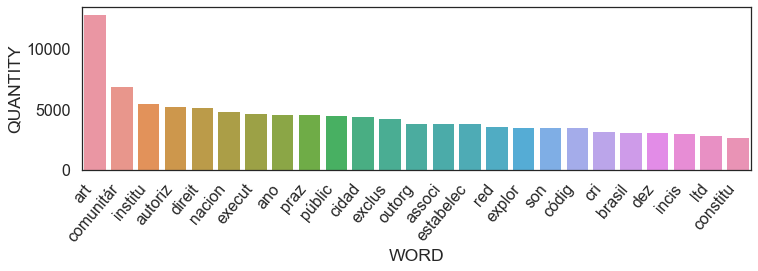

In [237]:
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wordcountplot = sns.barplot(x=wordcount["WORD"].head(25), y=wordcount["QUANTITY"].head(25), data=wordcount)
plt.setp(wordcountplot.get_xticklabels(), rotation=50, ha="right")
wordcountplot

Análise de palavras mais frequentes por classe

**COMUNICACOES**

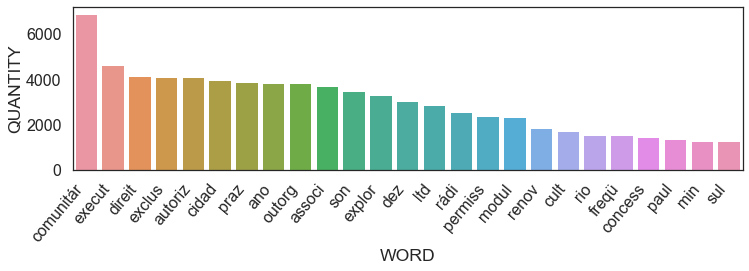

In [238]:
df_t_comun = corr_df_prop[corr_df_prop['TEMAS'] == 'COMUNICACOES']
wcount_comun = {}
for row in df_t_comun['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_comun:
            wcount_comun[word] = 1
        else:
            wcount_comun[word] += 1
wcount_comun = sorted(wcount_comun.items(), key=operator.itemgetter(1), reverse=True)
wcount_comun = pd.DataFrame.from_dict(wcount_comun)
wcount_comun.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_comun_plot = sns.barplot(x=wcount_comun["WORD"].head(25), y=wcount_comun["QUANTITY"].head(25), data=wcount_comun)
plt.setp(wcount_comun_plot.get_xticklabels(), rotation=50, ha="right")
wcount_comun_plot

**ADMINISTRACAO PUBLICA**

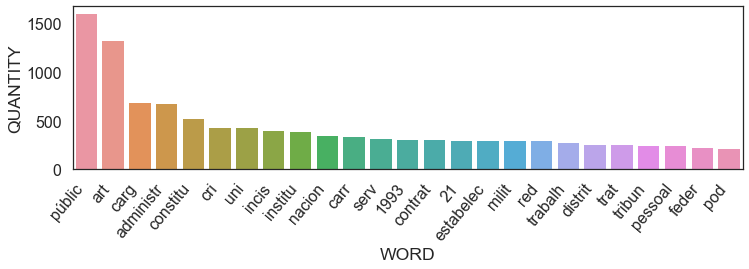

In [239]:
df_t_adminpub = corr_df_prop[corr_df_prop['TEMAS'] == 'ADMINISTRACAO PUBLICA']
wcount_adminpub = {}
for row in df_t_adminpub['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_adminpub:
            wcount_adminpub[word] = 1
        else:
            wcount_adminpub[word] += 1
wcount_adminpub = sorted(wcount_adminpub.items(), key=operator.itemgetter(1), reverse=True)
wcount_adminpub = pd.DataFrame.from_dict(wcount_adminpub)
wcount_adminpub.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_adminpub_plot = sns.barplot(x=wcount_adminpub["WORD"].head(25), y=wcount_adminpub["QUANTITY"].head(25), data=wcount_adminpub)
plt.setp(wcount_adminpub_plot.get_xticklabels(), rotation=50, ha="right")
wcount_adminpub_plot

**DIREITOS HUMANOS**

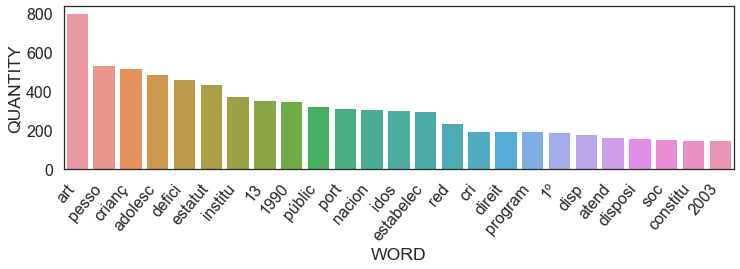

In [240]:
df_t_dirhum = corr_df_prop[corr_df_prop['TEMAS'] == 'DIREITOS HUMANOS']
wcount_dirhum = {}
for row in df_t_dirhum['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_dirhum:
            wcount_dirhum[word] = 1
        else:
            wcount_dirhum[word] += 1
wcount_dirhum = sorted(wcount_dirhum.items(), key=operator.itemgetter(1), reverse=True)
wcount_dirhum = pd.DataFrame.from_dict(wcount_dirhum)
wcount_dirhum.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_dirhum_plot = sns.barplot(x=wcount_dirhum["WORD"].head(25), y=wcount_dirhum["QUANTITY"].head(25), data=wcount_dirhum)
plt.setp(wcount_dirhum_plot.get_xticklabels(), rotation=50, ha="right")
wcount_dirhum_plot

**TRABALHO E EMPREGO**

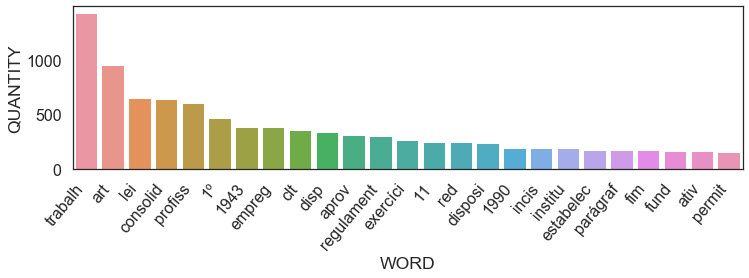

In [241]:
df_t_trabemp = corr_df_prop[corr_df_prop['TEMAS'] == 'TRABALHO E EMPREGO']
wcount_trabemp = {}
for row in df_t_trabemp['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_trabemp:
            wcount_trabemp[word] = 1
        else:
            wcount_trabemp[word] += 1
wcount_trabemp = sorted(wcount_trabemp.items(), key=operator.itemgetter(1), reverse=True)
wcount_trabemp = pd.DataFrame.from_dict(wcount_trabemp)
wcount_trabemp.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_trabemp_plot = sns.barplot(x=wcount_trabemp["WORD"].head(25), y=wcount_trabemp["QUANTITY"].head(25), data=wcount_trabemp)
plt.setp(wcount_trabemp_plot.get_xticklabels(), rotation=50, ha="right")
wcount_trabemp_plot

**EDUCACAO**

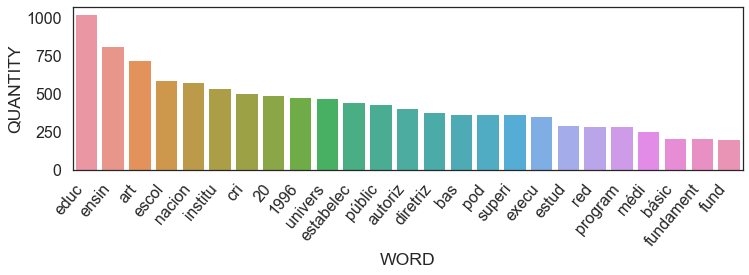

In [242]:
df_t_educ = corr_df_prop[corr_df_prop['TEMAS'] == 'EDUCACAO']
wcount_educ = {}
for row in df_t_educ['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_educ:
            wcount_educ[word] = 1
        else:
            wcount_educ[word] += 1
wcount_educ = sorted(wcount_educ.items(), key=operator.itemgetter(1), reverse=True)
wcount_educ = pd.DataFrame.from_dict(wcount_educ)
wcount_educ.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_educ_plot = sns.barplot(x=wcount_educ["WORD"].head(25), y=wcount_educ["QUANTITY"].head(25), data=wcount_educ)
plt.setp(wcount_educ_plot.get_xticklabels(), rotation=50, ha="right")
wcount_educ_plot

**TRIBUTACAO**

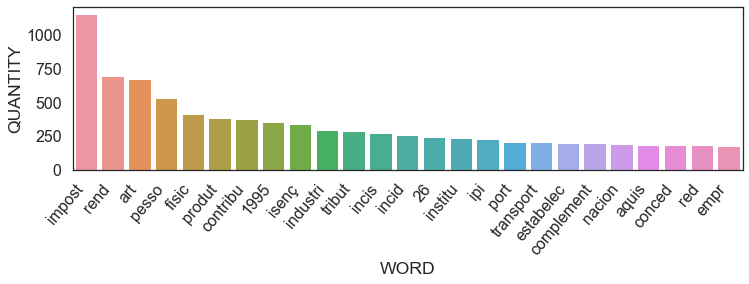

In [246]:
df_t_trib = corr_df_prop[corr_df_prop['TEMAS'] == 'TRIBUTACAO']
wcount_trib = {}
for row in df_t_trib['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_trib:
            wcount_trib[word] = 1
        else:
            wcount_trib[word] += 1
wcount_trib = sorted(wcount_trib.items(), key=operator.itemgetter(1), reverse=True)
wcount_trib = pd.DataFrame.from_dict(wcount_trib)
wcount_trib.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_trib_plot = sns.barplot(x=wcount_trib["WORD"].head(25), y=wcount_trib["QUANTITY"].head(25), data=wcount_trib)
plt.setp(wcount_trib_plot.get_xticklabels(), rotation=50, ha="right")
wcount_trib_plot

**SAUDE**

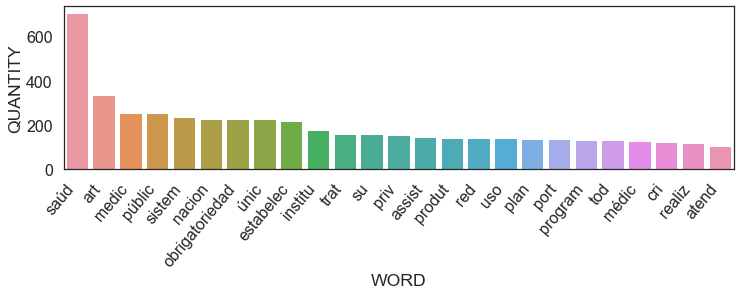

In [244]:
df_t_saude = corr_df_prop[corr_df_prop['TEMAS'] == 'SAUDE']
wcount_saude = {}
for row in df_t_saude['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_saude:
            wcount_saude[word] = 1
        else:
            wcount_saude[word] += 1
wcount_saude = sorted(wcount_saude.items(), key=operator.itemgetter(1), reverse=True)
wcount_saude = pd.DataFrame.from_dict(wcount_saude)
wcount_saude.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_saude_plot = sns.barplot(x=wcount_saude["WORD"].head(25), y=wcount_saude["QUANTITY"].head(25), data=wcount_saude)
plt.setp(wcount_saude_plot.get_xticklabels(), rotation=50, ha="right")
wcount_trabemp_plot

**DIREITO PENAL E PROCESSUAL PENAL**

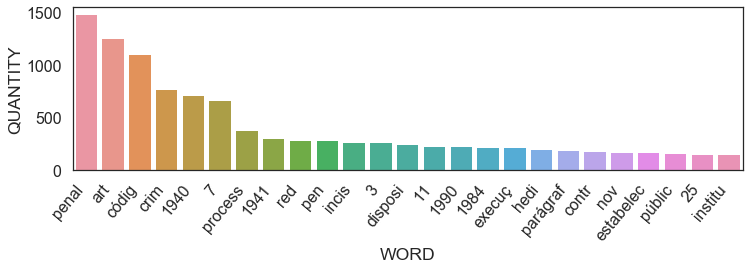

In [248]:
df_t_penal = corr_df_prop[corr_df_prop['TEMAS'] == 'DIREITO PENAL E PROCESSUAL PENAL']
wcount_penal = {}
for row in df_t_penal['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_penal:
            wcount_penal[word] = 1
        else:
            wcount_penal[word] += 1
wcount_penal = sorted(wcount_penal.items(), key=operator.itemgetter(1), reverse=True)
wcount_penal = pd.DataFrame.from_dict(wcount_penal)
wcount_penal.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_penal_plot = sns.barplot(x=wcount_penal["WORD"].head(25), y=wcount_penal["QUANTITY"].head(25), data=wcount_penal)
plt.setp(wcount_penal_plot.get_xticklabels(), rotation=50, ha="right")
wcount_penal_plot

**INDUSTRIA E COMERCIO**

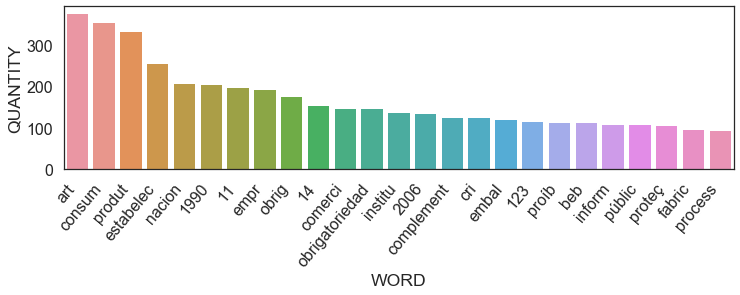

In [250]:
df_t_indcom = corr_df_prop[corr_df_prop['TEMAS'] == 'INDUSTRIA E COMERCIO']
wcount_indcom = {}
for row in df_t_indcom['TOKENWORDS'].iteritems():
    for word in str(row[1]).split():
        if word not in wcount_indcom:
            wcount_indcom[word] = 1
        else:
            wcount_indcom[word] += 1
wcount_indcom = sorted(wcount_indcom.items(), key=operator.itemgetter(1), reverse=True)
wcount_indcom = pd.DataFrame.from_dict(wcount_indcom)
wcount_indcom.columns = ['WORD', 'QUANTITY']
sns.set_context("poster")
sns.set_style('white')
plt.figure(figsize=(12,3))
wcount_indcom_plot = sns.barplot(x=wcount_indcom["WORD"].head(25), y=wcount_indcom["QUANTITY"].head(25), data=wcount_indcom)
plt.setp(wcount_indcom_plot.get_xticklabels(), rotation=50, ha="right")
wcount_indcom_plot

Estudo de atributos sintéticos: TAMANHO DO TEXTO

Verificando a média de tamanho das Strings dos TEMAS

In [262]:
counter = 1
sum_of_strings = 0
for row in df_t_indcom['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    print(sum_of_strings)
    counter += 1
    print('Counter: '+ str(counter))
    print('Median: '+ str(media))

168
Counter: 2
Median: 168.0
214
Counter: 3
Median: 107.0
259
Counter: 4
Median: 86.33333333333333
346
Counter: 5
Median: 86.5
386
Counter: 6
Median: 77.2
435
Counter: 7
Median: 72.5
538
Counter: 8
Median: 76.85714285714286
659
Counter: 9
Median: 82.375
689
Counter: 10
Median: 76.55555555555556
745
Counter: 11
Median: 74.5
851
Counter: 12
Median: 77.36363636363636
924
Counter: 13
Median: 77.0
1042
Counter: 14
Median: 80.15384615384616
1157
Counter: 15
Median: 82.64285714285714
1237
Counter: 16
Median: 82.46666666666667
1350
Counter: 17
Median: 84.375
1439
Counter: 18
Median: 84.6470588235294
1500
Counter: 19
Median: 83.33333333333333
1583
Counter: 20
Median: 83.3157894736842
1616
Counter: 21
Median: 80.8
1709
Counter: 22
Median: 81.38095238095238
1795
Counter: 23
Median: 81.5909090909091
1837
Counter: 24
Median: 79.8695652173913
1902
Counter: 25
Median: 79.25
1968
Counter: 26
Median: 78.72
2020
Counter: 27
Median: 77.6923076923077
2050
Counter: 28
Median: 75.92592592592592
2111
Counter

39515
Counter: 544
Median: 72.77163904235728
39606
Counter: 545
Median: 72.80514705882354
39728
Counter: 546
Median: 72.8954128440367
39760
Counter: 547
Median: 72.82051282051282
39781
Counter: 548
Median: 72.72577696526508
39826
Counter: 549
Median: 72.67518248175182
39871
Counter: 550
Median: 72.6247723132969
39910
Counter: 551
Median: 72.56363636363636
40018
Counter: 552
Median: 72.62794918330309
40127
Counter: 553
Median: 72.69384057971014
40249
Counter: 554
Median: 72.78300180831826
40348
Counter: 555
Median: 72.83032490974729
40492
Counter: 556
Median: 72.95855855855856
40536
Counter: 557
Median: 72.90647482014388
40573
Counter: 558
Median: 72.84201077199282
40682
Counter: 559
Median: 72.9068100358423
40743
Counter: 560
Median: 72.88550983899822
40784
Counter: 561
Median: 72.82857142857142
40838
Counter: 562
Median: 72.79500891265597
40872
Counter: 563
Median: 72.72597864768683
40977
Counter: 564
Median: 72.78330373001776
41041
Counter: 565
Median: 72.76773049645391
41087
Counter

Median: 72.10268714011517
75210
Counter: 1044
Median: 72.10930009587727
75233
Counter: 1045
Median: 72.06226053639847
75258
Counter: 1046
Median: 72.01722488038277
75337
Counter: 1047
Median: 72.02390057361377
75447
Counter: 1048
Median: 72.06017191977077
75578
Counter: 1049
Median: 72.11641221374046
75641
Counter: 1050
Median: 72.10772163965682
75679
Counter: 1051
Median: 72.07523809523809
75744
Counter: 1052
Median: 72.06850618458611
75817
Counter: 1053
Median: 72.06939163498099
75911
Counter: 1054
Median: 72.09021842355176
75934
Counter: 1055
Median: 72.04364326375712
76035
Counter: 1056
Median: 72.07109004739337
76057
Counter: 1057
Median: 72.02367424242425
76100
Counter: 1058
Median: 71.99621570482498
76162
Counter: 1059
Median: 71.98676748582231
76257
Counter: 1060
Median: 72.0084985835694
76280
Counter: 1061
Median: 71.9622641509434
76298
Counter: 1062
Median: 71.91140433553251
76359
Counter: 1063
Median: 71.90112994350282
76399
Counter: 1064
Median: 71.87111947318908
76484
Coun

Median: 71.73086900129702
110702
Counter: 1544
Median: 71.74465327284511
110775
Counter: 1545
Median: 71.74546632124353
110836
Counter: 1546
Median: 71.73851132686084
110901
Counter: 1547
Median: 71.73415265200518
110954
Counter: 1548
Median: 71.72204266321913
111041
Counter: 1549
Median: 71.73191214470285
111140
Counter: 1550
Median: 71.7495158166559
111191
Counter: 1551
Median: 71.73612903225806
111293
Counter: 1552
Median: 71.75564152159897
111303
Counter: 1553
Median: 71.71585051546391
111333
Counter: 1554
Median: 71.68898905344494
111389
Counter: 1555
Median: 71.67889317889318
111487
Counter: 1556
Median: 71.69581993569132
111526
Counter: 1557
Median: 71.67480719794345
111685
Counter: 1558
Median: 71.73089274245343
111755
Counter: 1559
Median: 71.72978177150192
111866
Counter: 1560
Median: 71.75497113534317
111929
Counter: 1561
Median: 71.74935897435897
112035
Counter: 1562
Median: 71.7713004484305
112101
Counter: 1563
Median: 71.76760563380282
112202
Counter: 1564
Median: 71.7863

In [266]:
counter = 1
sum_of_strings = 0
for row in df_t_comun['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 8855
Median: 91.78744070476621


In [267]:
counter = 1
sum_of_strings = 0
for row in df_t_trabemp['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 2592
Median: 69.32767271323813


In [268]:
counter = 1
sum_of_strings = 0
for row in df_t_saude['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 1800
Median: 76.7709838799333


In [270]:
counter = 1
sum_of_strings = 0
for row in df_t_educ['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 2511
Median: 76.2398406374502


In [271]:
counter = 1
sum_of_strings = 0
for row in df_t_trib['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 2137
Median: 84.37406367041199


In [272]:
counter = 1
sum_of_strings = 0
for row in df_t_dirhum['TOKENWORDS'].iteritems():
    sum_of_strings = sum_of_strings + len(row[1])
    media = sum_of_strings / counter
    counter += 1
print('Counter: '+ str(counter))
print('Median: '+ str(media))

Counter: 2613
Median: 76.55513016845329


In [290]:
corr_df_prop = corr_df_prop.assign(TOKENLENGTH=pd.Series().astype(str))
for idx, row in corr_df_prop.iterrows():
    if type(row['TOKENWORDS'])== int or type(row['TOKENWORDS'])== float:
        print(idx)
        print(row['TOKENWORDS'])
    else:
        corr_df_prop.at[corr_df_prop.index[idx], 'TOKENLENGTH'] = len(row['TOKENWORDS'])

In [280]:
corr_df_prop.head(20)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO,CODE_TEMAS,CODE_POLITICO,CODE_SEXO,CODE_PARTIDO,CODE_UF,CODE_REGIAO,TOKENWORDS,TOKENLENGTH
0,149439,2003,2794,PL 2794/2003,ADMINISTRACAO PUBLICA,TADEU FILIPPELLI,M,PMDB,DISTRITO FEDERAL,CENTRO-OESTE,"Dispõe sobre a alteração da Lei nº 8.666, de 2...",0,1269,1,9,6,0,alter 21 1993,14
1,475193,2010,7239,PL 7239/2010,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Acrescenta art. 31-A à Lei nº 8.987, de 13 de ...",0,-1,-1,-1,-1,-1,art 13 1995 regim concess permiss prest públi...,148
2,585601,2013,6004,PL 6004/2013,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Regulamenta o art. 37, inciso II, da Constitui...",0,-1,-1,-1,-1,-1,regulament art 37 incis ii constitu estabelec...,118
3,132101,2003,1912,PL 1912/2003,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Determina que as Assembléias Legislativas dos ...,0,-1,-1,-1,-1,-1,determin assemblé legisl est câm legisl distr...,113
4,134557,2003,170,PEC 170/2003,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Altera o caput do art. 37 da Constituição Fede...,0,-1,-1,-1,-1,-1,caput art 37 constitu inclu dentr princípi re...,82
5,332750,2006,7431,PL 7431/2006,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Autoriza o Poder Executivo a instituir o Piso ...,0,-1,-1,-1,-1,-1,autoriz pod execu institu pis salar profiss e...,89
6,274765,2005,358,PEC 358/2005,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Altera dispositivos dos arts. 21, 22, 29, 48, ...",0,-1,-1,-1,-1,-1,disposi art 21 22 29 48 93 95 96 98 102 104 1...,101
7,140438,2003,950,PDC 950/2003,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,Aprova as Contas dos Presidentes da Justiça El...,0,-1,-1,-1,-1,-1,cont presid justiç eleitor relat exercíci 2001,47
8,455582,2009,6242,PL 6242/2009,ADMINISTRACAO PUBLICA,NaN,NaN,NaN,NaN,NaN,"Altera a Lei nº 8.666, de 21 de junho de 1993,...",0,-1,-1,-1,-1,-1,21 1993 regulament art 37 incis xxi constitu ...,274
9,446198,2009,5836,PL 5836/2009,ADMINISTRACAO PUBLICA,RICARDO BARROS,M,PP,PARANÁ,SUL,"Altera a Lei nº 8.429, de 2 de junho de 1992, ...",0,1133,1,12,13,4,2 1992 sanç aplic agent públic cas enriquec i...,122


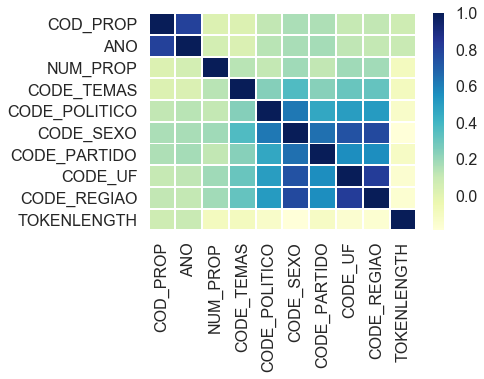

In [314]:
corr_df_prop['TOKENLENGTH'] = corr_df_prop['TOKENLENGTH'].astype(int)
sns.heatmap(corr_df_prop.corr(), cmap='YlGnBu',linecolor='white',linewidths=1)